In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [10]:


# Define basic sparse matrices (CSR format for efficient arithmetic)
sigma_z = sp.dia_matrix(([1, -1], 0), shape=(2, 2), dtype=complex).tocsr()
sigma_minus = sp.csr_matrix(([1], ([1], [0])), shape=(2, 2), dtype=complex)
identity = sp.eye(2, dtype=complex, format='csr')


def generate_sparse_fermionic_operators(N):
    """
    Generate sparse annihilation and creation operators for N orbitals with spin.
    
    Parameters:
    N (int): Number of orbitals.
    
    Returns:
    tuple: (annihilation_ops, creation_ops) where each is a list of 2N sparse matrices.
           The order is [orbital_0↑, orbital_0↓, orbital_1↑, orbital_1↓, ...].
    """
    
    total_modes = 2 * N
    annihilation_ops = []
    creation_ops = []
    
    for p in range(total_modes):
        # Initialize operator as a 1x1 identity matrix (to build Kronecker product)
        op = sp.eye(1, dtype=complex, format='csr')
        
        for q in range(total_modes):
            if q < p:
                term = sigma_z
            elif q == p:
                term = sigma_minus
            else:
                term = identity
            
            # Kronecker product with sparse matrices
            op = sp.kron(op, term, format='csr')
        
        annihilation_ops.append(op)
        creation_ops.append(op.conj().transpose())  # Hermitian adjoint
    
    return annihilation_ops, creation_ops

N = 8  # Number of orbitals
cs, cdags = generate_sparse_fermionic_operators(N)

In [11]:
#Generate hamiltonian for 2x2x2 orbital Kane-Mele model

NN_list = np.array([(1,2), (2, 3), (3,4), (5, 6), (5, 8), (7, 8), (2, 5)]) - 1
NNN_list = np.array([(1, 3), (5, 7), (1, 5), (1, 7), (2, 8), (4, 6), (2, 4), (6, 8), (2, 6)]) - 1

a = np.array([[1, 0],[-1/2, np.sqrt(3)/2],[-1/2, np.sqrt(3)/2]])
b = np.array([[0, np.sqrt(3)],[3/2, -np.sqrt(3)/2],[-3/2, -np.sqrt(3)/2]])


def g(k):
    return np.sum(np.exp(1j*a@k))

def g_bar(k):
    return np.sum(np.exp(1j*b@k))

def hamil(t, mu, U, l_so, k):
    hamiltonian = sp.csr_matrix((4**N, 4**N), dtype=complex)
    g_k = g(k)
    g_bar_k = g_bar(k)
    for NN in NN_list:
        hamiltonian+=(cdags[NN[0]*2]@cs[NN[1]*2]*g_k + cdags[NN[1]*2]@cs[NN[0]*2]*np.conj(g_k))*t*-1
        hamiltonian+=(cdags[NN[0]*2+1]@cs[NN[1]*2+1]*g_k + cdags[NN[1]*2+1]@cs[NN[0]*2+1]*np.conj(g_k))*t*-1
    for NNN in NNN_list:
        hamiltonian+=(cdags[NNN[0]*2]@cs[NNN[1]*2]*1j*g_bar_k + cdags[NNN[1]*2]@cs[NNN[0]*2]*np.conj(1j*g_bar_k))*l_so
        hamiltonian+=(cdags[NNN[0]*2+1]@cs[NNN[1]*2+1]*1j*g_bar_k + cdags[NNN[1]*2+1]@cs[NNN[0]*2+1]*np.conj(1j*g_bar_k))*l_so
    for i in range(N):
        hamiltonian+=cdags[i*2]@cs[i*2]@cdags[i*2+1]@cs[i*2+1]*U
        hamiltonian+=-mu*(cdags[i*2]@cs[i*2]+cdags[i*2+1]@cs[i*2+1])
    
    return hamiltonian

In [12]:
test_hamil = hamil(1, 5, 10, 0.3, (np.pi,np.pi))

In [13]:
evals, evecs = sp.linalg.eigsh(test_hamil, return_eigenvectors=True, which='SR')

In [14]:
cutoff = np.sum(np.abs((evals-evals[0]))<1e-10)

In [15]:
evecs[:,:cutoff]

array([[ 4.26984659e-18+8.51677413e-21j],
       [ 4.09568858e-19+1.22318897e-18j],
       [ 1.00061654e-18-1.58040800e-19j],
       ...,
       [-1.07410528e-18+1.95892582e-20j],
       [-2.97237348e-18+1.54234764e-18j],
       [ 5.78140751e-18-1.97088975e-18j]])

In [21]:
def get_occupancy(t, U, mu, l_so, k_num):
    
    k_range = np.arange(k_num)/k_num

    kx_range = np.array([[-1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]
    ky_range = np.array([[1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]
    
    occ_sum = 0
    acc = 1
    for kx in kx_range:
        for ky in ky_range:
            #print(str(acc)+"/"+str(k_num**2)); acc+=1;
            k = kx+ky
            hamil_k = hamil(t, mu, U, l_so, k)
            evals, evecs = sp.linalg.eigsh(hamil_k, return_eigenvectors=True, which='SR', k=4)
            cutoff = np.sum(np.abs((evals-evals[0]))<1e-10)
            gs_vecs = evecs[:,:cutoff]
            for i in range(2*N):
                occ_sum += (gs_vecs.conj().T@cdags[i]@cs[i]@gs_vecs).sum()/cutoff 
    
    return occ_sum/(k_num**2)/(2*N)

In [22]:
t = 1
U = 10
mu = U/2
l_so = 0.3
k_num = 20

mu_range = np.linspace(U/2 - U, U/2, 20)
occ_array = np.zeros_like(mu_range)

for ind, mu in enumerate(mu_range):
    print(ind, len(mu_range)-1)
    occ_array[ind] = get_occupancy(t, U, mu, l_so, k_num)

0 19


/tmp/ipykernel_219176/2117233224.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  occ_array[ind] = get_occupancy(t, U, mu, l_so, k_num)


1 19
2 19
3 19
4 19
5 19
6 19
7 19
8 19
9 19
10 19
11 19
12 19
13 19
14 19
15 19
16 19
17 19
18 19
19 19


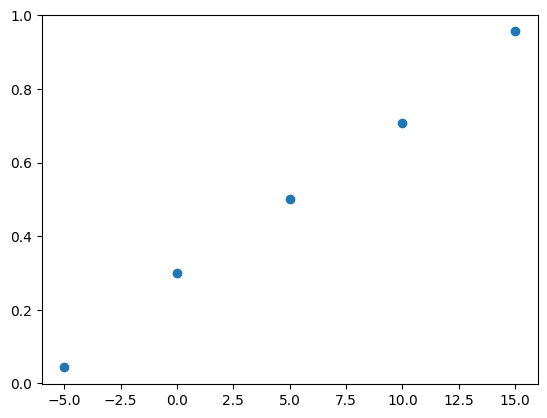

In [19]:
plt.scatter(mu_range,occ_array)

In [20]:
occ_array

array([0.0434375 , 0.30084444, 0.5       , 0.70757727, 0.9559375 ])

In [75]:
k_num = 20

k_range = (np.arange(k_num)-k_num/2)/k_num

kx_range = np.array([[-1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]
ky_range = np.array([[1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]

(-7.0, 7.0)

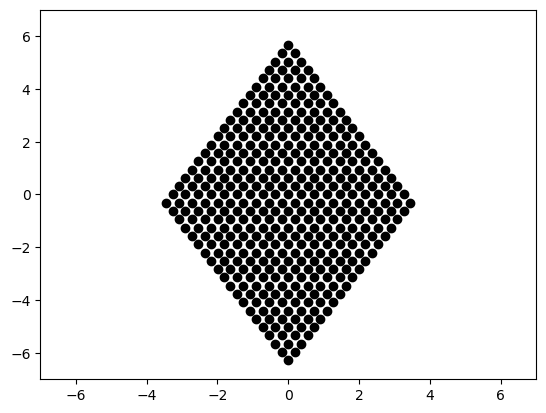

In [78]:

for kx in kx_range:
    for ky in ky_range:
        k = kx+ky
        #print(k[0], k[1])
        plt.scatter([k[0]], [k[1]], c='k')
        
plt.xlim(-7, 7)
plt.ylim(-7, 7)